In [1]:
from typing import Optional, Tuple
import os
import numpy as np
import torch
from tianshou.env import DummyVectorEnv

import torch

from pettingzoo.sisl import pursuit_v4
from TaskAllocation.RL_Policies.MultiHead_SISL import MultiHead_SISL

import os
import datetime
from typing import Optional, Tuple

import numpy as np
import torch
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager, RandomPolicy, RainbowPolicy
from TaskAllocation.RL_Policies.CNN_SISL import CNN_SISL

from pettingzoo.sisl import pursuit_v4

from TaskAllocation.RL_Policies.MultiHead_SISL import MultiHead_SISL
from TaskAllocation.RL_Policies.DNN_SISL import DNN_SISL

from TaskAllocation.RL_Policies.Custom_Classes import CustomCollector

#from tianshou_DQN import train
model = "CNN_SISL" #"MultiHead_SISL" 
policyModel = "DQN"

size = [16,16]
n_agents = 8
n_targes = 30
max_cycles = 500
obs_range = 7
render = False

seed = 0

# Create a new instance of the policy with the same architecture as the saved policy
# name = 'policy_CNN_SISL_01_Hot46231121-161700_2497_' 
name = 'policy_CNN_SISL_SISL_NOV12_Emb128231120-134122_5079' 
# name = 'policy_CNN_SISL_SISL_NOV12_ASAFull'

Policy_Config = {
    "same_policy" : True,
    "load_model" : True,
    "freeze_CNN" : True    
                }

dqn_params = {"discount_factor": 0.99, 
              "estimation_step": 1, 
              "target_update_freq": 800 * 4,
              "optminizer": "Adam",
              "lr": 1e-4 }

trainer_params = {"max_epoch": 500,
                  "step_per_epoch": 10 * (100 * 10 * 4),
                  "step_per_collect": 20 * (10 * 4),
                  "episode_per_test": 10,
                  "batch_size" : 4 * 32,
                  "update_per_step": 1 / 20, #Only run after close a Collect (run many times as necessary to meet the value)
                  "tn_eps_max": 0.95,
                  "ts_eps_max": 0.0,
                  }

def _get_env_eval():
    """This function is needed to provide callables for DummyVectorEnv."""   
    # env_paralell = MultiUAVEnv()  
    env = pursuit_v4.env(
        max_cycles=500,#max_cycles, 
        x_size=size[0], 
        y_size=size[1], 
        shared_reward=True, 
        n_evaders=n_targes,
        n_pursuers=n_agents,
        obs_range=obs_range, 
        n_catch=2, 
        freeze_evaders=False, 
        tag_reward=0.01,
        catch_reward=5.0, 
        urgency_reward=-0.1, 
        surround=True, 
        constraint_window=1.0,
        render_mode = "human" if render else None)
    #env = parallel_to_aec_wrapper(env_paralell)    
    #env = CustomParallelToAECWrapper(env_paralell)
    
    return PettingZooEnv(env)

def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    policy_load_path = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    
    env = _get_env_eval()     
    env.seed(seed)  
    agent_observation_space = env.observation_space
   
    action_shape = env.action_space
    
    device="cuda" if torch.cuda.is_available() else "cpu"  

    agents = []        
    
    if Policy_Config["same_policy"]:
        policies_number = 1
    else:
        policies_number = len(env.agents)

    for _ in range(policies_number):      
               
        if model == "CNN_SISL":
            net = CNN_SISL(
                obs_shape=agent_observation_space.shape,                
                action_shape=5,                
                device="cuda" if torch.cuda.is_available() else "cpu"
                
            ).to(device)            
              
        if Policy_Config["freeze_CNN"]:                
                net.freeze_conv_layers()  # Freeze the convolutional layers

                optim = torch.optim.Adam(
                    list(net.policy_fn.parameters()) + list(net.value_fn.parameters()), 
                    lr=dqn_params["lr"]
                )
        else:
            optim = torch.optim.Adam(net.parameters(), lr=dqn_params["lr"], weight_decay=0.0, amsgrad= True )                



        if policyModel == "DQN":
            agent_learn = DQNPolicy(
                model=net,
                optim=optim,
                action_space = action_shape,
                discount_factor= dqn_params["discount_factor"],
                estimation_step=dqn_params["estimation_step"],
                target_update_freq=dqn_params["target_update_freq"],
                reward_normalization = False,
                clip_loss_grad = False 
            ) 
         
        
        agents.append(agent_learn)

    if Policy_Config["same_policy"]:
        agents = [agents[0] for _ in range(len(env.agents))]    

    policy = MultiAgentPolicyManager(policies = agents, env=env)  
        
    return policy, optim, env.agents



policy, optim, agents = _get_agents()
     

# Load the saved checkpoint
for agent in agents:    
    
    if Policy_Config["same_policy"]:
        model_path = os.path.join("dqn_SISL", name + ".pth")                            
    else:
        model_path = os.path.join("dqn_SISL", name + agent + ".pth") 

    policy.policies[agent].set_eps(0.1)
    policy.policies[agent].load_state_dict(torch.load(model_path))
    # policy.policies[agent].eval()
    

envs = DummyVectorEnv([_get_env_eval for _ in range(1)])


collector = CustomCollector(policy, envs, exploration_noise=False)

results = collector.collect(n_episode=5, render=0.02 if render else None)#0.02)#, gym_reset_kwargs={'seed' :2})

print("FinalRew: ", np.sum(results['rews'], axis = 1))
print("Finished: ", results['lens'] , " Steps")

d:\Python310\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


FinalRew:  [492.43875 616.34375 407.63875 723.82    845.8725 ]
Finisehd:  [1064  920 1376 1200  832]  Steps


77.1528437500003


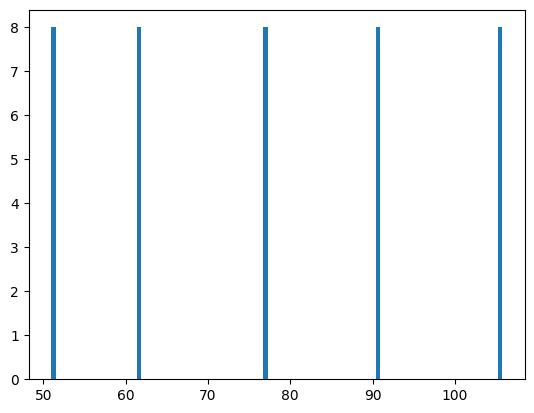

{'n/ep': 5, 'n/st': 5392, 'rews': array([[ 61.55484375,  61.55484375,  61.55484375,  61.55484375,
         61.55484375,  61.55484375,  61.55484375,  61.55484375],
       [ 77.04296875,  77.04296875,  77.04296875,  77.04296875,
         77.04296875,  77.04296875,  77.04296875,  77.04296875],
       [ 50.95484375,  50.95484375,  50.95484375,  50.95484375,
         50.95484375,  50.95484375,  50.95484375,  50.95484375],
       [ 90.4775    ,  90.4775    ,  90.4775    ,  90.4775    ,
         90.4775    ,  90.4775    ,  90.4775    ,  90.4775    ],
       [105.7340625 , 105.7340625 , 105.7340625 , 105.7340625 ,
        105.7340625 , 105.7340625 , 105.7340625 , 105.7340625 ]]), 'lens': array([1064,  920, 1376, 1200,  832]), 'idxs': array([0, 0, 0, 0, 0]), 'rew': 77.1528437500003, 'len': 1078.4, 'rew_std': 19.616714352468193, 'len_std': 194.60894121288467}


In [2]:
results['rews']
print(np.mean(results['rews'][results['rews'] > -10]))


#create a function  to print a histogram of the results['rews']
import matplotlib.pyplot as plt
plt.hist(results['rews'][results['rews'] > -10], bins=100)
plt.show()
print(results)